In [ ]:
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
import seaborn as sns
import re
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:

os.environ['PYTHONHASHSEED'] = '0'

In [ ]:
import random as rd

np.random.seed(123)

# start core Python generated random numbers in a well-defined state.
rd.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(123)

In [ ]:
from keras import backend as K


session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [ ]:

if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']


In [ ]:
#uncomment next line to see time taken by cell
#%%time

def load_tumor_data_np():

  images = np.load("/content/drive/MyDrive/Colab Notebooks/tumor_data_all/data_whole_official/tumor_im.npy", allow_pickle=True)
  masks = np.load("/content/drive/MyDrive/Colab Notebooks/tumor_data_all/data_whole_official/tumor_mask.npy", allow_pickle=True)
  labels = np.load("/content/drive/MyDrive/Colab Notebooks/tumor_data_all/data_whole_official/tumor_label.npy", allow_pickle=True)
  PIDs = np.load("/content/drive/MyDrive/Colab Notebooks/tumor_data_all/data_whole_official/tumor_PIDs.npy", allow_pickle=True)
  #integer_to_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary tumor'}
  #images = np.load("/content/drive/MyDrive/Colab Notebooks/tumor_data_all/labels/im_part3.npy", allow_pickle=True)

  print(f"images:{images.shape}, \
  masks:{masks.shape}, \
  labels:{labels.shape}")

  return images, masks, labels,PIDs

#resize images, to sg that can still be fitted to o computational perspective
def resize_images(images, image_size):
  images_new=[]
  for i in range (0,len(images)):
    image_new = cv2.resize(images[i], dsize=(image_size,image_size), interpolation=cv2.INTER_CUBIC)
    images_new.append(image_new)
    #smaller size so it doesnt crash
  images= np.array(images_new)
  return images

def extra_dim_give_images(images,image_size):
  images = np.array(images).reshape(-1, image_size,image_size, 1)
  return images

#make 3d tensor object, then imagenet weight can be used - then convert back to numpy array
def convert_to_rgb(images):
  images=tf.image.grayscale_to_rgb(
      tf.convert_to_tensor(images),
      name=None
  )
  images=images.numpy()
  return images
  
def image_preprocess(image_size, images):

  IMG_SIZE=image_size
  images=resize_images(images, image_size)
  images= extra_dim_give_images(images,image_size)
  images= convert_to_rgb(images)
  return images

#uncommenting the next lines will reduce to 100 observations, only for first look, quick computation
#X_train=images[600:700]
#y_train= labels[600:700]
image_size = 224
IMG_SIZE=image_size
original_images, masks, labels,PIDs=load_tumor_data_np()
images=image_preprocess(image_size, original_images)

X=images
y=labels



images:(3064, 512, 512),   masks:(3064, 512, 512),   labels:(3064,)


In [ ]:
#dont run this cell twice, otherwise it will zero out label column!
def make_labels_binary(y):  # 1 for glioma, 0 for non-glioma
  for i in range (0, len(y)):
    if y[i]!=2:
      y[i]=0

    if y[i]==2:
      y[i]=1
  return y

labels_binary = make_labels_binary(np.copy(y))
#after descriptive stats, before model fitting - because we want to investigate per tumor type
y=labels_binary

In [ ]:
###data cleaning
## transform patient id clean from arrays to a single string PID(patient id)  (array becomes python object)

def int_list_to_string_list(int_list):
  strings = []
  for element in int_list:
      strings.append(str(element))
  return strings

#  convert a list to string
def string_list_to_string_id(s):    
    # initialize an empty string
    str1 = "" 
    # traverse in the string  
    for ele in s: 
        str1 += ele   
    # return string  
    return str1 
def clean_special_chars(single_id_string):
  clean_string_1= re.sub('\[','',single_id_string)
  clean_string_2=re.sub('\]','',clean_string_1)
  return clean_string_2

def clean_a_PID_full(PIDs, i):

  int_list= PIDs[i]
  strings= int_list_to_string_list(int_list)
  single_id_string= string_list_to_string_id(strings)
  one_PIDs= clean_special_chars(single_id_string)
  return one_PIDs

clean_a_PID_full(PIDs, 1)




for i in range(0,len(PIDs)):
  PIDs[i]= clean_a_PID_full(PIDs, i)

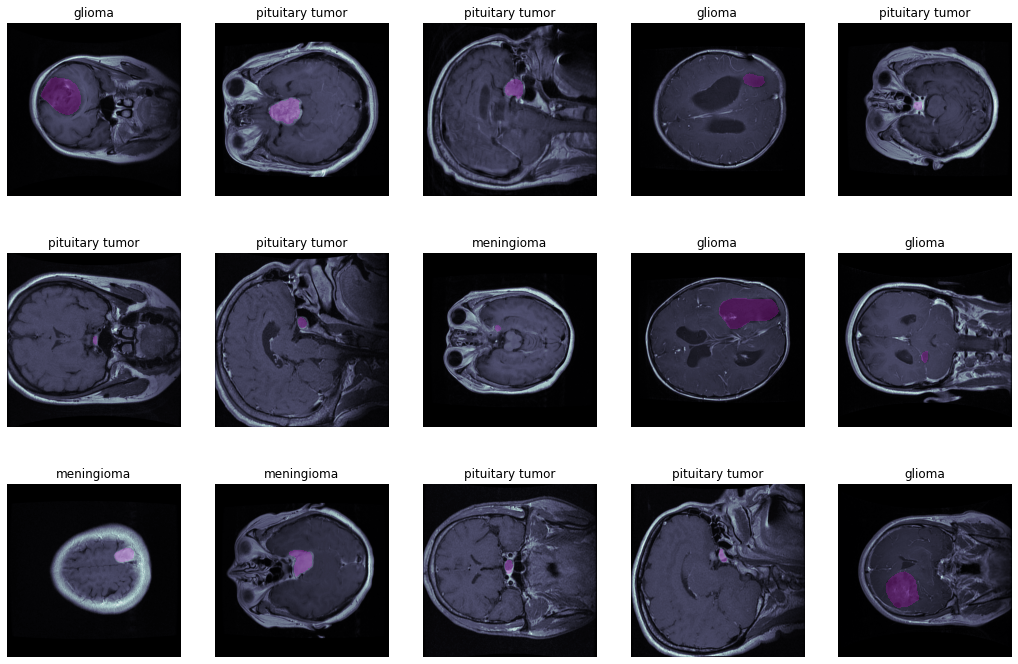

In [ ]:
# #descr stats

integer_to_class = {'1.0': 'meningioma', '2.0': 'glioma', '3.0': 'pituitary tumor'}

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18,12))
for i, idx in enumerate(np.random.randint(original_images.shape[0], size=15), start=1):
    plt.subplot(3, 5, i)
    plt.imshow(original_images[idx], cmap='bone')
    mask = np.ma.masked_where(masks[idx] == False, masks[idx])
    plt.imshow(mask, alpha=0.1, cmap='spring')
    
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

number of meningioma: 708
number of glioma: 1426
number of pituitary tumor: 930


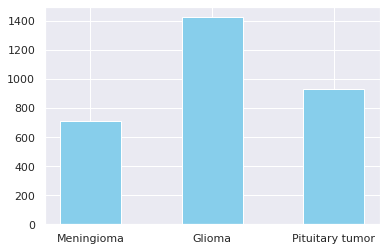

In [ ]:
import seaborn as sns
sns.set()
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts, width=0.5, color= 'skyblue', 
        tick_label=['Meningioma', 'Glioma', 'Pituitary tumor'])

for i, idx in enumerate(classes):
    print('number of {}: {}'.format(integer_to_class[str(idx)], counts[i]))

In [ ]:
#shufflw them so that types of tumor are nicely misked in intervals
X, y, PIDs, masks = shuffle(X,y,PIDs, masks ,random_state=123)

In [ ]:
def get_train_test_indices_patient_id_grouped(PIDs, X, y ):
  groups = PIDs 
  gss = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=123)

  for train_idx, test_idx in gss.split(X, y, groups):
    print("")
  return train_idx, test_idx

train_indices_patient_grouped, test_indices_patient_grouped=  get_train_test_indices_patient_id_grouped(PIDs, X, y)
#returns: indices split with no leakage between groups- 



In [ ]:
#seperate train test w no client splillage indices

X_train = X[train_indices_patient_grouped]
X_test = X[test_indices_patient_grouped]

y_train = y[train_indices_patient_grouped]
y_test = y[test_indices_patient_grouped]
#next choose train test datasets X and y with these indices, and run model

In [ ]:
#check for patient-wise data leakage for some ids randomly. id-s can be in only one set

if (PIDs[4]) in list(PIDs[train_indices_patient_grouped]) :
    print("in train set only" )

if (PIDs[4]) in list(PIDs[test_indices_patient_grouped]) :
    print("in test set only" )


in train set only


In [ ]:
#check for patient-wise data leakage for some ids randomly. id-s can be in only one set

if (PIDs[5]) in list(PIDs[train_indices_patient_grouped]) :
    print("in train set only" )

if (PIDs[5]) in list(PIDs[test_indices_patient_grouped]) :
    print("in test set only" )

in train set only


In [ ]:
#check for patient-wise data leakage for some ids randomly. id-s can be in only one set

if (PIDs[10]) in list(PIDs[train_indices_patient_grouped]) :
    print("in train set only" )

if (PIDs[10]) in list(PIDs[test_indices_patient_grouped]) :
    print("in test set only" )

in test set only


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape

(2261, 224, 224, 3)

In [ ]:
labels=[0,1]

In [ ]:
#one hot encode y for model
y_train_new = []
for i in y_train:
    #print(i)
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
#
from tensorflow.keras.applications import EfficientNetB0
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.2, seed=123)(model)
# why sigmoid  https://stackoverflow.com/a/59194285
model = tf.keras.layers.Dense(2,activation='sigmoid')(model) 
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

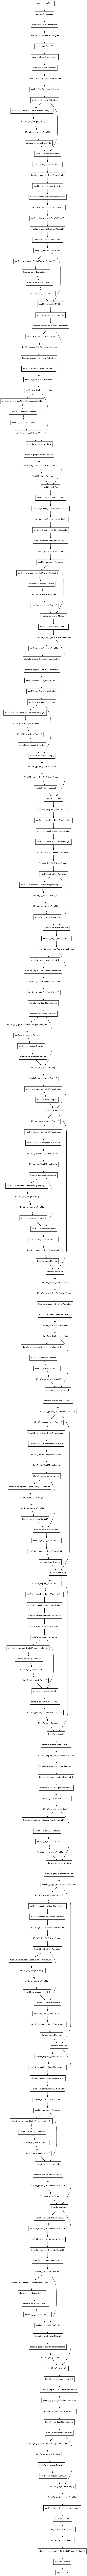

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

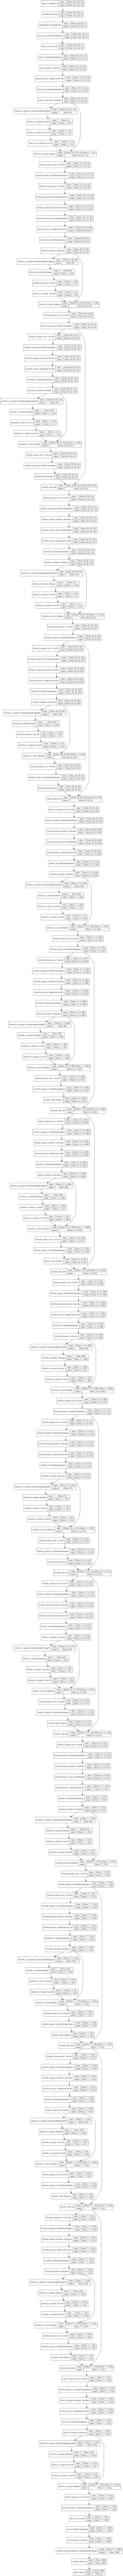

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [ ]:
model.compile(loss='binary_crossentropy',optimizer = 'Adam', metrics= [tf.keras.metrics.BinaryAccuracy( )])#threshold=0.2 -- DOESNT WORK(only in validation set but not when predicting)

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_binary_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_binary_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
%%time
#train model - w cpu 1-2hours, w google cloud, gpu 3-4 minutes

history = model.fit(np.asarray(X_train),np.asarray(y_train), validation_split=0.2, epochs =15, verbose=1, batch_size=32, 
                   callbacks=[tensorboard,checkpoint,reduce_lr])#validation_data=(X_test, y_test),  #change epochs back to 15 later

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/15
57/57 [==============================] - 39s 278ms/step - loss: 0.2046 - binary_accuracy: 0.9134 - val_loss: 0.2138 - val_binary_accuracy: 0.9415

Epoch 00001: val_binary_accuracy improved from -inf to 0.94150, saving model to effnet.h5
Epoch 2/15
57/57 [==============================] - 13s 223ms/step - loss: 0.0568 - binary_accuracy: 0.9787 - val_loss: 0.2468 - val_binary_accuracy: 0.9426

Epoch 00002: val_binary_accuracy improved from 0.94150 to 0.94260, saving model to effnet.h5
Epoch 3/15
57/57 [==============================] - 13s 223ms/step - loss: 0.0468 - binary_accuracy: 0.9873 - val_loss: 0.0621 - val_binary_accuracy: 0.9790

Epoch 00003: val_binary_accuracy improved from 0.94260 to 0.97903, saving model to effnet.h5
Epoch 4/15
57/57 [==============================] - 13s 221ms/step - loss: 0.0288 - binary_accuracy: 0.9912 - val_loss: 0.0497 - val_binary_accuracy: 0.9823

Epoch 00004: val_binary_accuracy improved from 0.97903 to 0.98234, saving model to effnet.h5

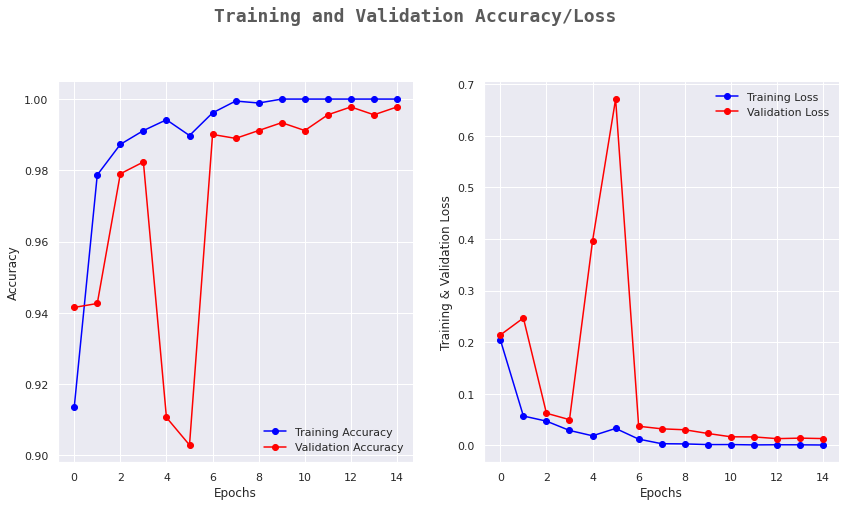

In [ ]:
filterwarnings('ignore')
epochs = [i for i in range(15)]
fig, ax = plt.subplots(1,2,figsize=(14,7))

train_acc = history.history['binary_accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_binary_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)
sns.despine()
ax[0].plot(epochs, train_acc, marker='o',color='blue',
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',color='red',
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',color='blue',
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',color='red',
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

In [ ]:


def predict_w_threshold(threshold, model, X_test ,y_test ):
  pred = model.predict(X_test)   
  print(pred[20:30])
  print (pred[0][0])

  pred = [1 * (x[0]<=threshold) for x in pred] 
  print (pred[20:30])
  #pred = np.argmax(pred,axis=1)
  y_test_new = np.argmax(y_test,axis=1)

  return pred, y_test_new
 #uncomment next line for threshold graphs 
pred, y_test_new = predict_w_threshold(0.5, model, X_test ,y_test )

[[9.9999177e-01 9.1772572e-06]
 [2.5512689e-05 9.9997318e-01]
 [9.9993932e-01 7.0751448e-05]
 [3.6190471e-08 1.0000000e+00]
 [9.9999940e-01 6.0574109e-07]
 [1.5918673e-06 9.9999869e-01]
 [9.9998784e-01 1.8674280e-05]
 [6.1625265e-08 1.0000000e+00]
 [7.4925239e-09 1.0000000e+00]
 [1.0673140e-06 9.9999893e-01]]
2.5438418e-08
[0, 1, 0, 1, 0, 1, 0, 1, 1, 1]


In [ ]:
def predict_no_threshold( model, X_test ,y_test):

  pred = model.predict(X_test) 
  print(pred)  
  #pred = [1 * (x[0]<=0.99) for x in pred] 
  pred = np.argmax(pred,axis=1)
  print(pred)
  y_test_new = np.argmax(y_test,axis=1)
  return pred, y_test_new


 #uncomment next line for no threshold graphs 
pred, y_test_new = predict_no_threshold( model, X_test ,y_test)

[[2.5438418e-08 1.0000000e+00]
 [9.9986410e-01 1.8431262e-04]
 [9.9999905e-01 1.2821087e-06]
 ...
 [2.9623150e-04 9.9977666e-01]
 [9.9999809e-01 2.2268139e-06]
 [9.0156550e-07 9.9999928e-01]]
[1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0
 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0
 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1
 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1
 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0
 0 0 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0
 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1
 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0
 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0
 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0
 0 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0

In [ ]:
X_test.shape

(803, 224, 224, 3)

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.03      0.03      0.03       356
           1       0.09      0.08      0.08       447

    accuracy                           0.06       803
   macro avg       0.06      0.05      0.06       803
weighted avg       0.06      0.06      0.06       803



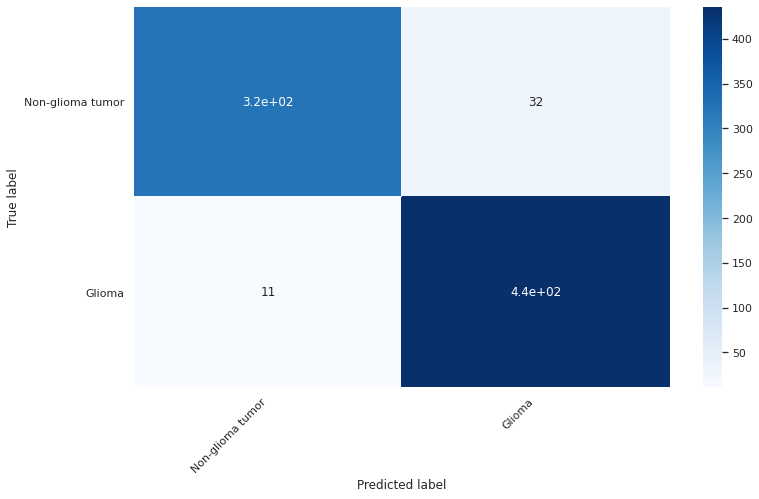

In [ ]:

plt.figure(figsize=(12, 7))
labels_conf= ["Non-glioma tumor","Glioma"]
labels_conf_y_axis= ["Non-glioma tumor", "Glioma"]
heatmap = sns.heatmap(confusion_matrix(y_test_new,pred), annot=True, cmap="Blues", xticklabels=labels_conf,yticklabels=labels_conf_y_axis)

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.show()    

In [ ]:

from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()  #keras_
y_test22=y_test.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test22, y_pred_keras)

In [ ]:

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
# (y_pred_keras<0.5).sum()
# (y_pred_keras<0.2).sum()

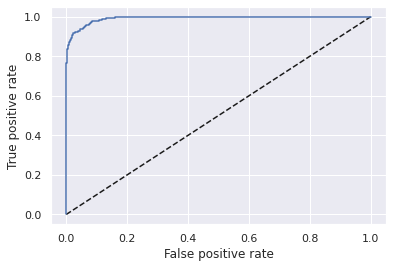

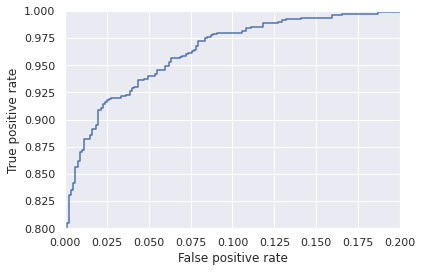

In [ ]:
#https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras )
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
#plt.title('ROC curve')
#plt.legend(loc='best')
plt.show()
# zoomed view
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
#plt.title('ROC curve (upper left block)')
#plt.legend(loc='best')
plt.show()